<a href="https://www.rhyme.com"> <img src="https://www.rhyme.com/assets/img/logo-dark.png" alt="Header" style="width: 100px;"/> </a>
<h1 align=center> Image Super Resolution using Autoencoders</h1>

<img src="images/high_res_v_low_res.jpg" width=550px>

## Task 1: Project Overview and Import Libraries

In [1]:
import os
import re
from scipy import ndimage, misc
from skimage.transform import resize, rescale
from matplotlib import pyplot
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(0)

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
import tensorflow as tf
print(tf.__version__)

2.2.0


## Task 2: What are Autoencoders?

<img src="images/autoencoder.jpg">
Credit: Autoencoder Schema by <a href="https://blog.keras.io/img/ae/autoencoder_schema.jpg">Francois Chollet, 2016</a>.

<h4 align=center>Encoder Architecture</h4>
<img src="images/encoder.png" width=450px align=center>

## Task 3: Build the Encoder

In [14]:
input_img = Input(shape = (256, 256, 3))
l1 = Conv2D(64, (3, 3), padding = 'same', activation = 'relu', activity_regularizer = regularizers.l1(10e-10), data_format = 'channels_last')(input_img)
l2 = Conv2D(64, (3, 3), padding = 'same', activation = 'relu', activity_regularizer = regularizers.l1(10e-10), data_format = 'channels_last')(l1)
l3 = MaxPooling2D(padding = 'same', data_format='channels_last')(l2)
l4 = Conv2D(128, (3, 3), padding = 'same', activation = 'relu', activity_regularizer = regularizers.l1(10e-10), data_format = 'channels_last')(l3)
l5 = Conv2D(128, (3, 3), padding = 'same', activation = 'relu', activity_regularizer = regularizers.l1(10e-10), data_format = 'channels_last')(l4)
l6 = MaxPooling2D(padding = 'same', data_format='channels_last')(l5)
l7 = Conv2D(256, (3, 3), padding = 'same', activation = 'relu', activity_regularizer = regularizers.l1(10e-10), data_format = 'channels_last')(l6)

encoder = Model(input_img, l7)

In [15]:
encoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 128, 128, 128)     147584    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 64, 64, 128)       0   

## Task 4: Build the Decoder to Complete the Network

<img src="images/decoder.png" width=450px>

In [16]:
input_img = Input(shape = (256, 256, 3))
l1 = Conv2D(64, (3, 3), padding = 'same', activation = 'relu', activity_regularizer = regularizers.l1(10e-10), data_format = 'channels_last')(input_img)
l2 = Conv2D(64, (3, 3), padding = 'same', activation = 'relu', activity_regularizer = regularizers.l1(10e-10), data_format = 'channels_last')(l1)
l3 = MaxPooling2D(padding = 'same', data_format='channels_last')(l2)
l4 = Conv2D(128, (3, 3), padding = 'same', activation = 'relu', activity_regularizer = regularizers.l1(10e-10), data_format = 'channels_last')(l3)
l5 = Conv2D(128, (3, 3), padding = 'same', activation = 'relu', activity_regularizer = regularizers.l1(10e-10), data_format = 'channels_last')(l4)
l6 = MaxPooling2D(padding = 'same', data_format='channels_last')(l5)
l7 = Conv2D(256, (3, 3), padding = 'same', activation = 'relu', activity_regularizer = regularizers.l1(10e-10), data_format = 'channels_last')(l6)


In [25]:
l8 = UpSampling2D(data_format='channels_last')(l7)
l9 = Conv2D(128, (3, 3), padding = 'same', activation = 'relu', activity_regularizer = regularizers.l1(10e-10), data_format = 'channels_last')(l8)
l10 = Conv2D(128, (3, 3), padding = 'same', activation = 'relu', activity_regularizer = regularizers.l1(10e-10), data_format = 'channels_last')(l9)
l11 = add([l5, l10])
l12 = UpSampling2D(data_format='channels_last')(l11)
l13 = Conv2D(64, (3, 3), padding = 'same', activation = 'relu', activity_regularizer = regularizers.l1(10e-10), data_format = 'channels_last')(l12)
l14 = Conv2D(64, (3, 3), padding = 'same', activation = 'relu', activity_regularizer = regularizers.l1(10e-10), data_format = 'channels_last')(l13)
l15 = add([l14, l2])

decoder = Conv2D(3, (3, 3), padding = 'same', activation = 'relu', activity_regularizer = regularizers.l1(10e-10), data_format = 'channels_last')(l15)

autoencoder = Model(input_img, decoder)

In [26]:
autoencoder.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 256, 256, 64) 1792        input_8[0][0]                    
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 256, 256, 64) 36928       conv2d_25[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_10 (MaxPooling2D) (None, 128, 128, 64) 0           conv2d_26[0][0]                  
____________________________________________________________________________________________

In [72]:
autoencoder.compile(optimizer='adam', loss='categorical_cross_entropy')

## Task 5: Create Dataset and Specify Training Routine

In [83]:
def train_batches(just_load_dataset=False):

    batches = 256

    batch = 0 
    batch_nb = 0 
    max_batches = -1 
    
    ep = 4 

    images = []
    x_train_n = []
    x_train_down = []
    
    x_train_n2 = [] 
    x_train_down2 = []
    
    for root, dirnames, filenames in os.walk(r"data/cars_train"):
        for filename in filenames:
            if re.search("\.(jpg|jpeg|JPEG|png|bmp|tiff)$", filename):
                if batch_nb == max_batches: 
                    print(batch_nb)
                    return x_train_n2, x_train_down2
                filepath = os.path.join(root, filename)
                image = pyplot.imread(filepath)
                if len(image.shape) > 2:
                        
                    image_resized = resize(image, (256, 256))
                    x_train_n.append(image_resized)
                    x_train_down.append(rescale(rescale(image_resized, 0.5), 2.0))
                    batch += 1
                    if batch == batches:
                        batch_nb += 1

                        x_train_n2 = np.array(x_train_n)
                        x_train_down2 = np.array(x_train_down)
                        
                        
                        if just_load_dataset:
                            return x_train_n2, x_train_down2
                        
                        print('Training batch', batch_nb, '(', batches, ')')

                        autoencoder.fit(x_train_down2, x_train_n2,
                            epochs=ep,
                            batch_size=10,
                            shuffle=True,
                            validation_split=0.15)
                    
                        x_train_n = []
                        x_train_down = []
                    
                        batch = 0

    return x_train_n2, x_train_down2

## Task 6: Load the Dataset and Pre-trained Model

In [84]:
x_train_n, x_train_down = train_batches(just_load_dataset=True)

In [85]:
x_train_down

array([[[[0.33726848, 0.40785671, 0.42353203],
         [0.33726848, 0.40785671, 0.42353203],
         [0.32677038, 0.39735862, 0.41308707],
         ...,
         [0.97142289, 0.9929654 , 0.99307088],
         [0.9719912 , 0.99362472, 0.99365991],
         [0.9719912 , 0.99362472, 0.99365991]],

        [[0.33726848, 0.40785671, 0.42353203],
         [0.33726848, 0.40785671, 0.42353203],
         [0.32677038, 0.39735862, 0.41308707],
         ...,
         [0.97142289, 0.9929654 , 0.99307088],
         [0.9719912 , 0.99362472, 0.99365991],
         [0.9719912 , 0.99362472, 0.99365991]],

        [[0.32619954, 0.39678777, 0.41228012],
         [0.32619954, 0.39678777, 0.41228012],
         [0.32395011, 0.39453835, 0.40999484],
         ...,
         [0.96546176, 0.98711152, 0.98741307],
         [0.96696976, 0.98879929, 0.98889988],
         [0.96696976, 0.98879929, 0.98889988]],

        ...,

        [[0.66939626, 0.67544174, 0.62709229],
         [0.66939626, 0.67544174, 0.62709229]

In [86]:
autoencoder.load_weights('data/sr.img_net.mse.final_model5.no_patch.weights.best.hdf5')

## Task 7: Model Predictions and Visualizing the Results

In [87]:
encoder.load_weights('data/encoder_weights.hdf5')

In [88]:
encoded_imgs = encoder.predict(x_train_down)

In [89]:
sr1 = np.clip(autoencoder.predict(x_train_down), 0.0, 1.0)

In [90]:
sr1

array([[[[0.24353099, 0.22821778, 0.25547624],
         [0.30315733, 0.37508813, 0.38935798],
         [0.35214216, 0.3813164 , 0.39236966],
         ...,
         [0.95747393, 0.9131398 , 0.9458486 ],
         [0.8630178 , 0.86689055, 0.8526336 ],
         [0.54285365, 0.5820198 , 0.61882794]],

        [[0.3564787 , 0.3124788 , 0.3691853 ],
         [0.43715298, 0.48181713, 0.48434484],
         [0.48446202, 0.4921004 , 0.49287742],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [0.7766201 , 0.9049898 , 0.8112769 ]],

        [[0.35867137, 0.3285532 , 0.37469122],
         [0.43944836, 0.46691054, 0.48756346],
         [0.45638806, 0.46728215, 0.48878935],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [0.7860062 , 0.8830117 , 0.90963364]],

        ...,

        [[0.65033644, 0.5779271 , 0.58508164],
         [0.8281756 , 0.8367314 , 0.7636137 ]

In [92]:
image_index = np.random.randint(0, 256)

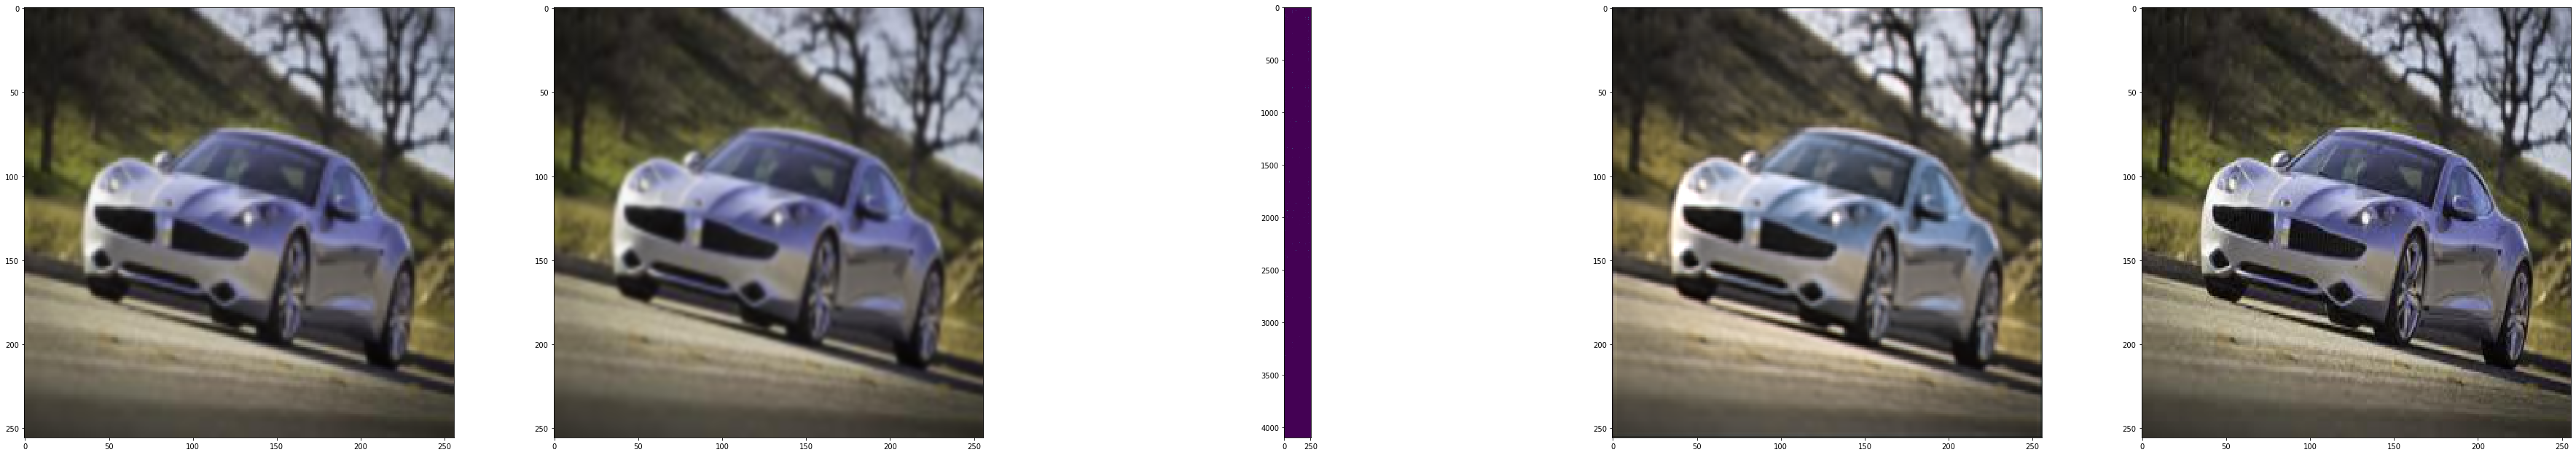

In [93]:
plt.figure(figsize=(128, 128))
i = 1
ax = plt.subplot(10, 10, i)
plt.imshow(x_train_down[image_index])
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(x_train_down[image_index], interpolation='bicubic')
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(encoded_imgs[image_index].reshape((64*64),256))
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(sr1[image_index])
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(x_train_n[image_index])

plt.show()